In [156]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [166]:
run_200_300 = pd.read_csv('data/20211026T184846_200-300-iperf.csv')
run_200_1000 = pd.read_csv('data/20211026T184846_200-1000-iperf.csv')
run_200_25000 = pd.read_csv('data/20211026T184846_200-25000-iperf.csv')
run_200_5000 = pd.read_csv('data/20211026T184847_200-5000-iperf.csv')

In [167]:
def pckt_count(a):
    a = a.split(';')
    a = [int(i) for i in a[:-1]]
    return len(a)

In [168]:
run_200_300['pck_ct'] = run_200_300['packet_times'].apply(pckt_count)
run_200_1000['pck_ct'] = run_200_1000['packet_times'].apply(pckt_count)
run_200_25000['pck_ct'] = run_200_25000['packet_times'].apply(pckt_count)
run_200_5000['pck_ct'] = run_200_5000['packet_times'].apply(pckt_count)

In [169]:
run_200_5000['packet_size_total'] = run_200_5000['1->2Pkts'] + run_200_5000['2->1Pkts']
run_200_300['packet_size_total'] = run_200_300['1->2Pkts'] + run_200_300['2->1Pkts']
run_200_1000['packet_size_total'] = run_200_1000['1->2Pkts'] + run_200_1000['2->1Pkts']
run_200_25000['packet_size_total'] = run_200_25000['1->2Pkts'] + run_200_25000['2->1Pkts']

In [170]:
ratio_200_5000  = [0.04 for i in range(310)] 
ratio_200_300 = [0.67 for i in range(324)]
ratio_200_1000 = [0.2 for i in range(318)]
ratio_200_25000 = [0.008 for i in range(308)]

In [171]:
run_200_5000['ratio'] = ratio_200_5000
run_200_300['ratio'] = ratio_200_300
run_200_1000['ratio'] = ratio_200_1000
run_200_25000['ratio'] = ratio_200_25000

In [163]:
#optional - take out first 25 seconds of data
run_200_5000 = run_200_5000[25:]
run_200_300 = run_200_300[25:]
run_200_1000 = run_200_1000[25:]
run_200_25000 = run_200_25000[25:]

In [172]:
def agg_10sec(df):
    new_df = pd.DataFrame()
    min_time = df["Time"][0]
    ratio = df["ratio"][0]
    while min_time < df["Time"][len(df)-1]:
        temp_df = df[(df["Time"] >= min_time) & (df["Time"] < min_time+10)]
        row = temp_df[["1->2Bytes", "2->1Bytes", "1->2Pkts", "2->1Pkts", "packet_size_total", "pck_ct"]].sum().to_frame().T
        row["packet_sizes_var"] = temp_df["packet_size_total"].var()
        row["Time"] = min_time
        row["ratio"] = ratio
        new_df = new_df.append(row)
        min_time += 10
    return new_df.reset_index(drop=True)

In [173]:
agg_200_300 = agg_10sec(run_200_300)
agg_200_1000 = agg_10sec(run_200_1000)
agg_200_5000 = agg_10sec(run_200_5000)
agg_200_25000 = agg_10sec(run_200_25000)

In [174]:
full_df = pd.concat([agg_200_300, agg_200_1000, agg_200_5000, agg_200_25000])

In [175]:
full_df

,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_size_total,pck_ct,packet_sizes_var,Time,ratio
0,3574904,80308,2388,1385,3773,3773,110925.174242,1635274126,0.670
1,1663556,15576,1110,288,1398,1398,2329.090909,1635274136,0.670
2,1458056,12760,973,238,1211,1211,1558.490909,1635274146,0.670
3,1459500,14576,973,272,1245,1245,188.055556,1635274156,0.670
4,1411500,15008,941,278,1219,1219,154.322222,1635274166,0.670
...,...,...,...,...,...,...,...,...,...
25,32833500,413324,21889,7919,29808,29808,215362.844444,1635274377,0.008
26,33055556,377144,22038,7223,29261,29261,892171.690909,1635274387,0.008
27,33223500,388016,22149,7430,29579,29579,151043.655556,1635274397,0.008
28,33231000,387564,22154,7425,29579,29579,162448.544444,1635274407,0.008


In [178]:
# Load the diabetes dataset
features = ['packet_size_total', 'pck_ct', 'packet_sizes_var', 'Time']
df_X = full_df[features]
df_y = full_df['ratio']

# Use only one feature
#diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train, X_rem, y_train, y_rem = train_test_split(df_X, df_y, train_size=0.8, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-8.55909837e-06 -8.55909837e-06  2.47716419e-08 -3.95488031e-05]
Mean squared error: 0.04
Coefficient of determination: 0.47


ValueError: x and y must be the same size

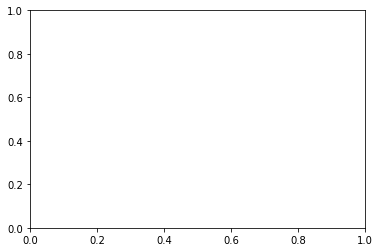

In [150]:
# Plot outputs
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()